## Import Base Libraries

In [7]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau

import cv2
import mediapipe as mp

## Load Data

In [95]:
train_df = pd.read_csv("./input/sign_language_mnist/sign_mnist_train.csv")
test_df = pd.read_csv("./input/sign_language_mnist/sign_mnist_test.csv")

In [96]:
train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27455 entries, 0 to 27454
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 164.4 MB


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [97]:
test_df.info()
test_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7172 entries, 0 to 7171
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 43.0 MB


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


## Pre-process Data

### Split Labels and Data

In [142]:
train_label = train_df["label"]
train_set = train_df.drop(["label"], axis=1)

test_label = test_df["label"]
test_set = test_df.drop(["label"], axis=1)

In [145]:
len(train_label.unique())

24

In [143]:
sorted(train_label.unique())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24]

### Reshape data from 1-D to 3-D

In [122]:
X_train = np.reshape(train_set.values, (-1, 28, 28, 1))
X_test = np.reshape(test_set.values, (-1, 28, 28, 1))

print(X_train.shape)
print(X_test.shape)



(27455, 28, 28, 1)
(7172, 28, 28, 1)


In [123]:
# Normalize dataset (divide ea. pixel by 255 so that pixel range = [0, 1]
X_train = X_train/255
X_test = X_test/255

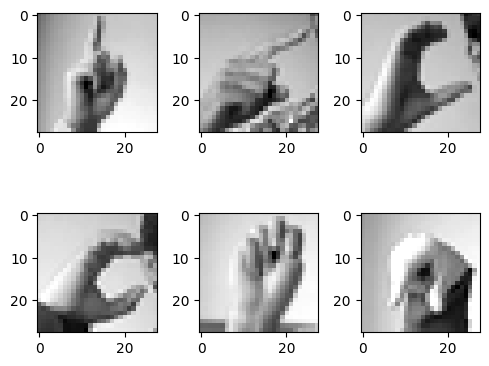

In [125]:
f, ax = plt.subplots(2,3) 
f.set_size_inches(5, 5)
k = 0
for i in range(2):
    for j in range(3):
        ax[i,j].imshow(X_train[k] , cmap = "gray")
        k += 1
    plt.tight_layout()   

### Convert Integer Labels (0-24) to Binary

In [64]:
lb = LabelBinarizer()
y_train = lb.fit_transform(train_label)
y_test = lb.fit_transform(test_label)

## Data Augmentation

In [65]:
X_train.mean()

0.6246706203880206

In [66]:
datagen = ImageDataGenerator(
    rescale=1/255,
    horizontal_flip=True,
    zoom_range=0.1,
    rotation_range=10,
    height_shift_range=0.2,
    width_shift_range=0.2
)

datagen.fit(X_train)

In [71]:
datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 0,
                                  height_shift_range=0.2,
                                  width_shift_range=0.2,
                                  shear_range=0,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')


datagen.fit(X_train)

In [81]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

# Creating our Convolutional Neural Network

In [71]:
model = Sequential()

# Conv Layer 1
model.add(Conv2D(128, kernel_size=(5,5), strides=1, padding='same', activation='relu', input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(3,3), strides=2, padding='same'))

# Conv Layer 2
model.add(Conv2D(64, kernel_size=(3,3), strides=1, padding='same', activation='relu', input_shape=(28,28,1)))
model.add(MaxPool2D((2,2),2,padding='same'))

# Conv Layer 3
model.add(Conv2D(32, kernel_size=(2,2), strides=1, padding='same', activation='relu', input_shape=(28,28,1)))
model.add(MaxPool2D((2,2),2,padding='same'))

model.add(Flatten())
model.add(Dense(units=512,activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=24,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 128)       3328      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          8224      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 32)          0

In [85]:
model = Sequential()
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 28, 28, 75)        750       
                                                                 
 batch_normalization_3 (Bat  (None, 28, 28, 75)        300       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 75)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_4 (Bat  (None, 14, 14, 50)       

In [86]:
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

### Fit the Model w/ Train

## Attempt 3

In [77]:
model = Sequential()
model.add(Conv2D(128,kernel_size=(5,5),
                 strides=1,padding='same',activation='relu',input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(3,3),strides=2,padding='same'))
model.add(Conv2D(64,kernel_size=(2,2),
                strides=1,activation='relu',padding='same'))
model.add(MaxPool2D((2,2),2,padding='same'))
model.add(Conv2D(32,kernel_size=(2,2),
                strides=1,activation='relu',padding='same'))
model.add(MaxPool2D((2,2),2,padding='same'))
          
model.add(Flatten())
model.add(Dense(units=512,activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=24,activation='softmax'))
model.summary()

model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 28, 28, 128)       3328      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 14, 14, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 14, 14, 64)        32832     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 7, 7, 32)          8224      
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 4, 4, 32)         

In [82]:
model.fit(datagen.flow(X_train,y_train,batch_size=200),
         epochs = 35,
          validation_data=(X_test,y_test),
          shuffle=1,
          callbacks = [learning_rate_reduction]
         )

Epoch 1/35
138/138 [==============================] - 31s 221ms/step - loss: 2.2877 - accuracy: 0.2971 - val_loss: 1.0162 - val_accuracy: 0.6744 - lr: 5.0000e-04
Epoch 2/35
138/138 [==============================] - 31s 222ms/step - loss: 0.9580 - accuracy: 0.6801 - val_loss: 0.5077 - val_accuracy: 0.8410 - lr: 5.0000e-04
Epoch 3/35
138/138 [==============================] - 30s 220ms/step - loss: 0.5631 - accuracy: 0.8099 - val_loss: 0.3724 - val_accuracy: 0.8635 - lr: 5.0000e-04
Epoch 4/35
138/138 [==============================] - 30s 219ms/step - loss: 0.4037 - accuracy: 0.8655 - val_loss: 0.2781 - val_accuracy: 0.9098 - lr: 5.0000e-04
Epoch 5/35
138/138 [==============================] - 30s 219ms/step - loss: 0.3127 - accuracy: 0.8987 - val_loss: 0.2394 - val_accuracy: 0.9197 - lr: 5.0000e-04
Epoch 6/35
138/138 [==============================] - 30s 219ms/step - loss: 0.2510 - accuracy: 0.9177 - val_loss: 0.1364 - val_accuracy: 0.9631 - lr: 5.0000e-04
Epoch 7/35
138/138 [========

In [83]:
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

225/225 [==============================] - 3s 12ms/step - loss: 0.0566 - accuracy: 0.9872
Accuracy of the model is -  98.71723651885986 %


In [84]:
model.save("asl_mnist_98.h5")

D:\Anaconda3\envs\sc4031\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Attempt 2

In [89]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

model.fit(datagen.flow(X_train, y_train, batch_size=128),
          epochs = 20,
          validation_data=(X_test, y_test),
          shuffle=1,
          callbacks = [learning_rate_reduction]
         )

Epoch 1/20
215/215 [==============================] - 41s 183ms/step - loss: 1.0797 - accuracy: 0.6650 - val_loss: 3.2743 - val_accuracy: 0.1482 - lr: 0.0010
Epoch 2/20
215/215 [==============================] - 38s 177ms/step - loss: 0.2018 - accuracy: 0.9330 - val_loss: 1.1774 - val_accuracy: 0.6065 - lr: 0.0010
Epoch 3/20
215/215 [==============================] - 38s 177ms/step - loss: 0.0964 - accuracy: 0.9691 - val_loss: 0.1687 - val_accuracy: 0.9431 - lr: 0.0010
Epoch 4/20
215/215 [==============================] - 40s 184ms/step - loss: 0.0608 - accuracy: 0.9807 - val_loss: 0.0292 - val_accuracy: 0.9921 - lr: 0.0010
Epoch 5/20
215/215 [==============================] - 39s 182ms/step - loss: 0.0434 - accuracy: 0.9868 - val_loss: 0.0363 - val_accuracy: 0.9883 - lr: 0.0010
Epoch 6/20
215/215 [==============================] - ETA: 0s - loss: 0.0366 - accuracy: 0.9887
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
215/215 [=============================

In [90]:
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

225/225 [==============================] - 3s 14ms/step - loss: 7.9849e-04 - accuracy: 1.0000
Accuracy of the model is -  100.0 %


In [91]:
model.save("asl_mnist_100.h5")

D:\Anaconda3\envs\sc4031\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Attempt 1 (Fail?)

In [73]:
model.fit(datagen.flow(X_train, y_train, batch_size=128),
          epochs = 20,
          validation_data=(X_test, y_test),
          shuffle=1
         )

Epoch 1/20
215/215 [==============================] - 45s 199ms/step - loss: 3.1769 - accuracy: 0.0471 - val_loss: 3.2569 - val_accuracy: 0.0201
Epoch 2/20
215/215 [==============================] - 42s 194ms/step - loss: 3.1760 - accuracy: 0.0463 - val_loss: 3.2713 - val_accuracy: 0.0201
Epoch 3/20
215/215 [==============================] - 39s 180ms/step - loss: 3.1760 - accuracy: 0.0460 - val_loss: 3.2698 - val_accuracy: 0.0201
Epoch 4/20
215/215 [==============================] - 39s 180ms/step - loss: 3.1759 - accuracy: 0.0453 - val_loss: 3.2767 - val_accuracy: 0.0201
Epoch 5/20
215/215 [==============================] - 40s 185ms/step - loss: 3.1761 - accuracy: 0.0467 - val_loss: 3.2727 - val_accuracy: 0.0201
Epoch 6/20
215/215 [==============================] - 39s 179ms/step - loss: 3.1760 - accuracy: 0.0453 - val_loss: 3.2780 - val_accuracy: 0.0201
Epoch 7/20
215/215 [==============================] - 39s 179ms/step - loss: 3.1759 - accuracy: 0.0460 - val_loss: 3.2783 - val_ac

### Model Evaluation

In [81]:
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {score[1]*100}%')

Test Accuracy: 15.658114850521088%


# Webcam Test with Mediapipe

## Load Model (if needed)

In [126]:
model = load_model("./output/asl_mnist_100.h5")
# model = load_model("./output/asl_mnist_98.h5")

## Setup Mediapipe

In [89]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

hands = mp_hands.Hands()

## Pre-Process Image/Frame

In [90]:
def preprocess_image(frame):
    # Convert image to RGB format
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Normalize pixel values to [0, 1]
    img = img.astype(np.float32) / 255.0

    # Resize (just need 28x28 since our dataset has a total of 784 pixels)
    img = cv2.resize(img, (28, 28))

    # Reshape
    # img = np.reshape(img, (-1, 28, 28, 1))
    
    return img

In [149]:
def convert_img_to_pixels(img):
    pixel_list = []
    rows, cols = img.shape

    for i in range(rows):
        for j in range(cols):
            pixel_value = img[i, j]
            pixel_list.append(pixel_value)

    img_pd = pd.DataFrame(pixel_list).T

    # Generate column names (784 columns for each pixel)
    pixel_cols = []
    for val in range(784):
        pixel_cols.append(val)

    # Set pd columns as pixel numbers
    img_pd.columns = pixel_cols

    predict_data = img_pd.values
    predict_data = predict_data.reshape(-1, 28, 28, 1)
    predict_data = predict_data / 255 # Normalize to [0, 1]

    return predict_data

## Load Video Capture

In [175]:
import time
import math
from cvzone.HandTrackingModule import HandDetector

label_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']

## Use cvzone

In [179]:
cap = cv2.VideoCapture(0)
detector = HandDetector(maxHands=1)
IMG_SIZE = 300

while True:
    success, frame = cap.read()
    hands, frame = detector.findHands(frame)

    if hands:
        hand = hands[0]
        x, y, w, h = hand['bbox']

        # Get bounding box for detected hand
        offset = 20
        frame_crop = frame[y-offset:y+h+offset, x-offset:x+w+offset]
        frame_crop_shape = frame_crop.shape
        
        frame_white = np.ones((IMG_SIZE, IMG_SIZE, 3), np.uint8) * 255
    
        aspect_ratio = h/w

        if aspect_ratio > 1:
            k = IMG_SIZE/h
            w_cal = math.ceil(k*w)
            w_gap = math.ceil((IMG_SIZE-w_cal)/2)

            frame_resize = cv2.resize(frame_crop, (w_cal, IMG_SIZE))
            frame_resize_shape = frame_resize.shape
            
            if frame_crop_shape[0] <= 300 and frame_crop_shape[1] <= 300:
                frame_white[:, w_gap:w_cal+w_gap] = frame_resize

        else:
            k = IMG_SIZE/w
            h_cal = math.ceil(k*h)
            h_gap = math.ceil((IMG_SIZE-h_cal)/2)

            frame_resize = cv2.resize(frame_crop, (IMG_SIZE, h_cal))
            frame_resize_shape = frame_resize.shape
            
            if frame_crop_shape[0] <= 300 and frame_crop_shape[1] <= 300:
                frame_white[h_gap:h_cal+h_gap, :] = frame_resize

        cv2.imshow("Cropped", frame_crop)
        cv2.imshow("White", frame_white)
        
    
    cv2.imshow("Webcam", frame)

    # Break the loop when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break 

# Release the webcam and close all windows
cap.release()
cv2.destroyAllWindows()

## Use Mediapipe

In [ ]:
cap = cv2.VideoCapture(0)
label_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']


with mp_hands.Hands() as hands:
    while True:
        # Capture frame by frame
        ret, frame = cap.read()
        h, w, c = frame.shape

        # img = preprocess_image(frame)
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(img)

        #if cv2.waitKey(1) & 0xFF == ord('f'):
        # Check Left or Right
        #print(f"Handedness: ${results.multi_handedness}")

        hand_landmarks = results.multi_hand_landmarks
        if hand_landmarks:
            analysis_frame = frame

            for hand_lm in hand_landmarks:
                x_max = 0
                y_max = 0
                x_min = w
                y_min = h
                for lm in hand_lm.landmark:
                    x, y = int(lm.x * w), int(lm.y * h)
                    if x > x_max:
                        x_max = x
                    if x < x_min:
                        x_min = x
                    if y > y_max:
                        y_max = y
                    if y < y_min:
                        y_min = y
                        
                y_min -= 20
                y_max += 20
                x_min -= 20
                x_max += 20
                cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
                mp_drawing.draw_landmarks(frame, hand_lm, mp_hands.HAND_CONNECTIONS)

        
        cv2.imshow('Webcam', frame)
    
        # Break the loop when 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break 

# Release the webcam and close all windows
cap.release()
cv2.destroyAllWindows()

In [164]:
cap = cv2.VideoCapture(0)
label_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']


with mp_hands.Hands() as hands:
    while True:
        # Capture frame by frame
        ret, frame = cap.read()
        h, w, c = frame.shape

        # img = preprocess_image(frame)
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(img)

        #if cv2.waitKey(1) & 0xFF == ord('f'):
        # Check Left or Right
        #print(f"Handedness: ${results.multi_handedness}")

        hand_landmarks = results.multi_hand_landmarks
        if hand_landmarks:
            analysis_frame = frame

            for hand_lm in hand_landmarks:
                x_max = 0
                y_max = 0
                x_min = w
                y_min = h
                for lm in hand_lm.landmark:
                    x, y = int(lm.x * w), int(lm.y * h)
                    if x > x_max:
                        x_max = x
                    if x < x_min:
                        x_min = x
                    if y > y_max:
                        y_max = y
                    if y < y_min:
                        y_min = y
                        
                y_min -= 20
                y_max += 20
                x_min -= 20
                x_max += 20
                cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
                mp_drawing.draw_landmarks(frame, hand_lm, mp_hands.HAND_CONNECTIONS)
            
            if cv2.waitKey(1) & 0xFF == ord('f'):
                '''
                for hand_lm in hand_landmarks:
                    x_max = 0
                    y_max = 0
                    x_min = w
                    y_min = h
                    for lm in hand_lm.landmark:
                        x, y = int(lm.x * w), int(lm.y * h)
                        if x > x_max:
                            x_max = x
                        if x < x_min:
                            x_min = x
                        if y > y_max:
                            y_max = y
                        if y < y_min:
                            y_min = y
                            
                    y_min -= 20
                    y_max += 20
                    x_min -= 20
                    x_max += 20
                    cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
                    mp_drawing.draw_landmarks(frame, hand_lm, mp_hands.HAND_CONNECTIONS)
                    '''
    
                # Set Frame to Analyse as Cropped Hand
                # analysis_frame = cv2.cvtColor(frame[y_min:y_max, x_min:x_max], cv2.COLOR_BGR2GRAY)'

                
                analysis_frame = cv2.cvtColor(analysis_frame, cv2.COLOR_BGR2GRAY)
                analysis_frame = analysis_frame[y_min:y_max, x_min:x_max]

                if(analysis_frame.size):
                    analysis_frame = cv2.resize(analysis_frame, (28, 28))
    
                    # Pre-process image for prediction 
                    # analysis_frame = preprocess_image(analysis_frame)
    
                    predict_frame = convert_img_to_pixels(analysis_frame)
            
                    # Prediction
                    predictions = model.predict(predict_frame)
                    pred_array = np.array(predictions[0])
    
                    label_list_dict = {label_list[i]: pred_array[i] for i in range(len(label_list))}
    
                    pred_array_ordered = sorted(pred_array, reverse=True)

                    print(pred_array_ordered[0])
    
                    for key, value in label_list_dict.items():
                        print(value)
                        if value == pred_array_ordered[0]:
                            #print("Predicted Character 1: ", key)
                            #print('Confidence 1: ', 100*value)

                            if(key == "P"):
                                cv2.putText(frame, key, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                            else:
                                cv2.putText(frame, key, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                            
                        #elif value == pred_array_ordered[1]:
                            #print("Predicted Character 2: ", key)
                            #print('Confidence 2: ', 100*value)
                            
                        #elif value == pred_array_ordered[2]:
                            #print("Predicted Character 3: ", key)
                            #print('Confidence 3: ', 100*value)

                    
    
                    '''
                    predicted_class_index = np.argmax(predictions)
                    # Map the predicted index to class label
                    predicted_label = labels[predicted_class_index]
                    
                    # Print the predicted label
                    print("Predicted label:", predicted_label)
                    '''
                    
                    '''
                    predarray = np.array(prediction[0])
                    letter_prediction_dict = {letterpred[i]: predarray[i] for i in range(len(letterpred))}
                    predarrayordered = sorted(predarray, reverse=True)
                    high1 = predarrayordered[0]
                    high2 = predarrayordered[1]
                    high3 = predarrayordered[2]
                    for key,value in letter_prediction_dict.items():
                        if value==high1:
                            print("Predicted Character 1: ", key)
                            print('Confidence 1: ', value)
    
                    '''
                    # time.sleep(3)
        
        cv2.imshow('Webcam', frame)
    
        # Break the loop when 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break 

# Release the webcam and close all windows
cap.release()
cv2.destroyAllWindows()

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:971: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'cv::imshow'
